necessary videos

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import accuracy_score
from sys import getsizeof

from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy



print(tf. __version__)

2.8.0


In [2]:
# from calendar import EPOCH


IMAGE_SIZE = 256
BATCH_SIZE = 32   #Standard batch size
CHANNELS = 3
EPOCHS = 5


In [6]:
# Specify directory first
# one call will load all the images into tensorflow


In [7]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage", #directory
    shuffle=True,   # To randomly shuffle the images.
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
)

Found 8081 files belonging to 5 classes.


In [8]:
class_names = dataset.class_names
class_names

['Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [9]:
label_filename = 'class_names.txt'
# model.export(label_filename)

In [10]:
# 68 * 32
len(dataset)

253

In [11]:
#explore images.
for image_batch, label_batch in dataset.take(1):
    # print(image_batch.shape)
    # print(image_batch[0])
    print(image_batch[0].numpy())  #convert it into numpy
    print(image_batch[0].shape)

    # Every element that you get is a tensor,so you need to
    #  convert it to numpu
    # print(label_batch.numpy())

[[[153. 144. 137.]
  [163. 154. 147.]
  [193. 184. 177.]
  ...
  [176. 165. 159.]
  [139. 128. 122.]
  [198. 187. 181.]]

 [[229. 220. 213.]
  [160. 151. 144.]
  [179. 170. 163.]
  ...
  [156. 145. 139.]
  [165. 154. 148.]
  [134. 123. 117.]]

 [[165. 156. 149.]
  [143. 134. 127.]
  [154. 145. 138.]
  ...
  [141. 130. 124.]
  [142. 131. 125.]
  [139. 128. 122.]]

 ...

 [[158. 148. 138.]
  [151. 141. 131.]
  [154. 144. 134.]
  ...
  [135. 123. 111.]
  [140. 128. 116.]
  [157. 145. 133.]]

 [[160. 150. 140.]
  [144. 134. 124.]
  [142. 132. 122.]
  ...
  [130. 118. 106.]
  [149. 137. 125.]
  [154. 142. 130.]]

 [[170. 160. 150.]
  [147. 137. 127.]
  [141. 131. 121.]
  ...
  [140. 128. 116.]
  [158. 146. 134.]
  [141. 129. 117.]]]
(256, 256, 3)


Visualize images.

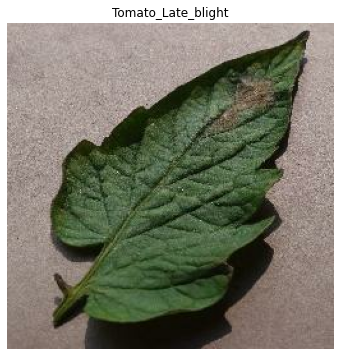

In [12]:
plt.figure(figsize=(6, 6))
for image_batch, label_batch in dataset.take(1):
    # plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.imshow(image_batch[0].numpy().astype("uint8"))


    # labelling the title
    plt.title(class_names[label_batch[0]])
    # Remove the axis labeling
    plt.axis("off")

Displaying a many images once

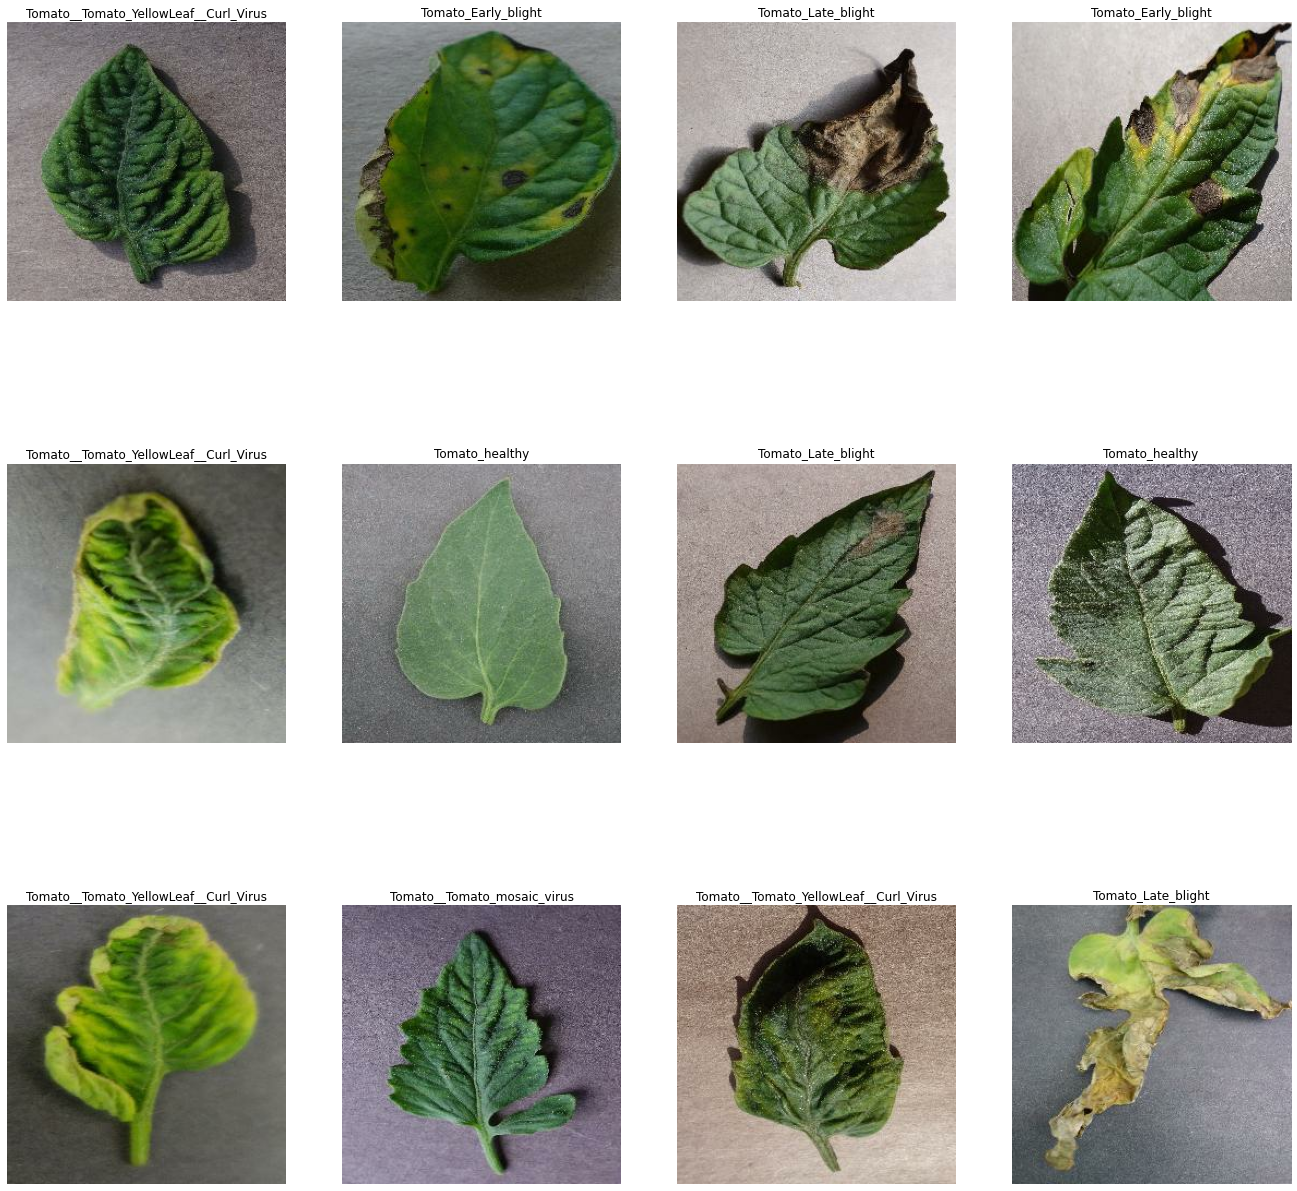

In [13]:
#Increase the dimension
plt.figure(figsize=(23, 23))
for image_batch, label_batch in dataset.take(1):
    
    for i in range(12):
        ax = plt.subplot(3, 4, i +1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))

        # labelling the title
        plt.title(class_names[label_batch[i]])
        # Remove the axis labeling
        plt.axis("off")

Spliting our dataset into training and testing

In [14]:
len(dataset)

253

In [15]:
#  80% ==> training
#  20% ==> 10% validation, 10 % test

In [16]:
train_size = 0.8
len(dataset) * train_size

202.4

I will take 54

In [20]:
train_ds = dataset.take(202)
len(train_ds)

202

The ramaining will  be for test

In [22]:
test_ds = dataset.skip(202)
len(test_ds)

51

I need 10% for validation

In [23]:
val_size = 0.1
len(dataset) *val_size

25.3

In [25]:
# Taking 10 % from training dataset
val_ds = test_ds.take(25)
len(val_ds)

25

In [26]:
# The actual testind dataset. 
test_ds = test_ds.skip(25)
len(test_ds)

26

Creating a function

In [27]:


def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1, test_split=0.1, shuffle=True,shuffle_size=10000):

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)




    return train_ds, val_ds, test_ds

In [28]:
# Calling the function above
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [30]:
print(f"Length of train dataset is : {len(train_ds)}")
print(f"Length of validation dataset is : {len(val_ds)}")
print(f"Length of test dataset is : {len(test_ds)}")


Length of train dataset is : 202
Length of validation dataset is : 25
Length of test dataset is : 26


caching. In data science, repetitions of the same routines could be cached to speed the experiments or decrease data access latency. The most straightforward adaptation policy is to take advantage of the locality of reference principle.

In [31]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)



Preprocessing

In [32]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # Preprocessing API
    layers.experimental. preprocessing.Rescaling(1.0/255)
    ])

Argumentation

In [33]:
data_augumentation = tf.keras.Sequential(
    [layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
    ]
)

Creating the Model

In [34]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    # resize_and_rescale,
    data_augumentation,
    layers.Conv2D(32,(3, 3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size = (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation ='softmax'),


]
    
)
model.build(input_shape=input_shape)

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [36]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

Training the network


In [37]:
# from tabnanny import verbose


history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/5


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\traitlets\config\application.py", line 972, in launch_instance
      app.start()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\jaycee\AppData\Local\Temp\ipykernel_11740\3147691143.py", line 4, in <cell line: 4>
      history = model.fit(
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 860, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 918, in compute_loss
      return self.compiled_loss(
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 201, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 141, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 245, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\losses.py", line 1862, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\jaycee\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\backend.py", line 5202, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
Received a label value of 4 which is outside the valid range of [0, 3).  Label values: 4 1 1 2 1 1 2 0 4 0 1 1 1 1 2 3 2 1 1 2 4 2 1 2 0 1 0 2 2 2 1 1
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_2769]

#  run the test dataset

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.history.keys()

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Ploting Training Accuracy and Validation accuracy

In [ ]:
from cProfile import label


# plt.figure(figsize= 8)
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()


In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    # How to display image
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")

    plt.imshow(first_image)
    plt.axis("off")
    print("actual label:", class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])


In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)    # Create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(23, 23))
for images, labels in test_ds.take(1):

    for i in range(9):
        # To show all the images
        ax = plt.subplot(3, 3, i + 1)

        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy)
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")


In [ ]:
# import os
# model_version = max([int(i) for i in os.listdir("saved_models") + [0]]) + 1
# KERAS_MODEL_NAME = model.save(f"saved_models/{model_version}.h5")
# KERAS_MODEL_NAME

In [ ]:
KERAS_MODEL_NAME = "tf_model_fashion_mnist.h5"
model.save(KERAS_MODEL_NAME)



In [ ]:
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size
def convert_bytes(size, unit=None):
    if unit == "KB":
        return print('File Size: ' + str(round(size/1024, 3)) + 'Kilobytes')
    elif unit == 'MB':
        return print('File Size: ' + str(round(size/(1024*1024), 3)) + 'Megabytes')
    else:
        return print('File Size: ' + str(size) + 'bytes')

In [ ]:
convert_bytes(get_file_size(KERAS_MODEL_NAME), "MB")

In [ ]:
LITE_MODEL_FILE_NAME = "tf_lite_model.tflite"
tf_lite_converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = tf_lite_converter.convert()



In [ ]:
tflite_model_name = LITE_MODEL_FILE_NAME
open(tflite_model_name, "wb").write(tflite_model)


In [ ]:
convert_bytes(get_file_size(LITE_MODEL_FILE_NAME), "KB")

In [ ]:
from numpy import dtype


interpreter = tf.lite.Interpreter(model_path=LITE_MODEL_FILE_NAME)
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])
